# Cup detection

### To build and to tune a simple detection model I will use:

In [1]:
import cv2
import imutils as imt
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import xml.etree.ElementTree as ET
import math
import numpy as np
from functools import reduce

## Preparing

I have prepared dataset from an example video. I cut frames from this video by using ffmpeg. After that, I marked cups by using labelImg application (https://github.com/tzutalin/labelImg). I did it to tune a detection model.

## Read dataset

In [2]:
ROOT_PATH = "training/data/cut_video"

def xml_to_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

### Let's see one of the samples.

In [3]:
def show_row(row):
    img = cv2.imread(ROOT_PATH +"/" + row.filename, 1)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    lt_point = (row.xmin, row.ymin)
    rb_point = (row.xmax, row.ymax)
    COLOR = (0,255,0)
    cv2.rectangle(img, lt_point, rb_point, COLOR, 4)
    plt.imshow(img)

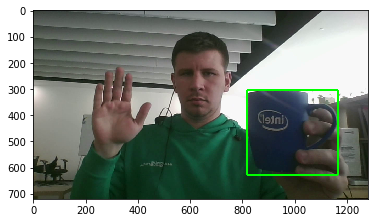

In [4]:
df = xml_to_df(ROOT_PATH + "/annotations")
show_row(df.iloc[3])

## Detection models

### Simple HSV treshhold model.

I will use information about a cup color. It seems to me we can find this cup in the HSV color model by finding a color interval. To do that I apply a symmetric couple of the threshold function for each color dimensions. After that, I can apply logic operation AND between the color dimension. The result matrix I will call a color mask matrix.

In [5]:
def thresh_holding(rgb, color, weight):
    img = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    thresh_lambda = lambda ind: cv2.bitwise_and(\
                cv2.threshold(img[:,:,ind],\
                color[ind]-weight[ind],255,\
                cv2.THRESH_BINARY)[1],\
                cv2.threshold(img[:,:,ind],\
                color[ind]+weight[ind],255,\
                cv2.THRESH_BINARY_INV)[1],\
                )

    thrs = [thresh_lambda(i) for i in range(3)]
    rgthr = cv2.bitwise_and(thrs[0], thrs[1])
    bthr = cv2.bitwise_and(thrs[2], rgthr)
    return bthr


### Let's see the color mask matrix.

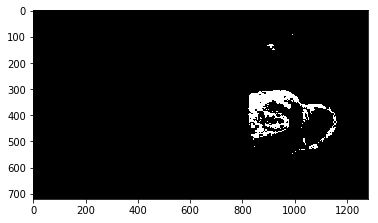

In [6]:
img = cv2.imread(ROOT_PATH +"/" + df.iloc[3].filename,1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = thresh_holding(img, (125,70,70), (20,40,40))
plt.imshow(img, cmap="gray")

### Prehandling

I apply adaptive histogram equalization for input picture. It a little bit allows avoiding the problem with different brightness and contrasts. OpenCV has CLAHE for it.

In [7]:
def prehandling(bgr, clipLimit=20.0, tileGridSize=(6,6)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

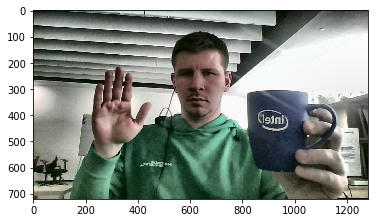

In [8]:
img = cv2.imread(ROOT_PATH +"/" + df.iloc[3].filename,1)
img = prehandling(img, clipLimit=5)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap="gray")

### Let's see the effect of prehandling to color mask matrix.

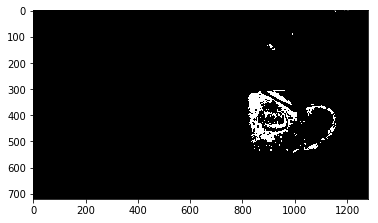

In [9]:
img = cv2.imread(ROOT_PATH +"/" + df.iloc[3].filename,1)
img = prehandling(img, clipLimit=5, tileGridSize=(6,6))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = thresh_holding(img, (125,60,70), (20,40,40))
plt.imshow(img, cmap="gray")

## Detecting process

### Area overlap calculate function

To avoid the same bounding boxes I have to estimate the area overlap of this boxes.

In [10]:
def area_of_rect(rect):
    return abs(rect[0][0] - rect[1][0]) * abs(rect[0][1] - rect[1][1])

def overlap_area(rect1, rect2):
    """
    calculate area overlap
    rect is two point left top and bottom right
    """
    delta_x = min(rect2[1][0], rect1[1][0]) - max(rect2[0][0], rect1[0][0])
    delta_y = min(rect2[1][1], rect1[1][1]) - max(rect2[0][1], rect1[0][1])
    return delta_x * delta_y if delta_x > 0 and delta_y > 0 else 0
    
    
def overlap(rect1, rect2):
    """
    calculate area overlap in RELATION
    rect is two point left top and bottom right
    """
    common = overlap_area(rect1, rect2)
    area1 = area_of_rect(rect1)
    area2 = area_of_rect(rect2)
    return 2 * common / (area1 + area2)


### Detection function

To find bounding boxes I will use a matchTemplate OpenCV function. I will fill a template with max_value. After that, I will apply it to color_mask_matrix. To avoid duplicates I will union rectangles with a big overlap area.

In [11]:
def windows_fill_calc(color_mask_matrix,  window_size=250, threshhold=0.5, overlap_threshhold=0.75):
    
    template = np.full((window_size, window_size), 255, dtype=color_mask_matrix.dtype)
    
    matchResult = cv2.matchTemplate(color_mask_matrix, template, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matchResult)
    
    #handmade normalization
    res = matchResult / 1 
    
    
    #plt.imshow(res, cmap="gray")
    results = []
    min_val, max_val, min_loc, max_loc = 0, 1, 0, 0
    while max_val > threshhold:
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > threshhold:
            bottom_right = (max_loc[0]+window_size, max_loc[1]+window_size)
            results.append((max_loc, bottom_right))
            
            #to avoid finding this place the next time
            res[max_loc[1]:bottom_right[1], max_loc[0]:bottom_right[0]] = 0
    
    
    #union rectangles with a big overlap area
    i = 0
    while i < len(results):
        detect = results[i]
        
        j = 0
        while j < len(results):
            if j != i and overlap(detect, results[j]) > overlap_threshhold:
                #union two rect
                xl, xr = min(detect[0][0], results[j][0][0]), max(detect[1][0], results[j][1][0])
                yl, yr = min(detect[0][1], results[j][0][1]), max(detect[1][1], results[j][1][1])
                results[i] = ((xl, yl), (xr, yr))
                detect = results[i]
                
                
                results.remove(results[j])
                
                if j < i:
                    i -= 1
            j += 1
        
        i += 1
                
                
    
    return results
       
        

### Let's see the example of work with no tuned parameters.

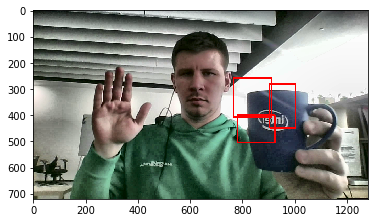

In [12]:
def draw_detections(img, detections):
    COLOR = (255, 0, 0)
    for detected in detections:
        cv2.rectangle(img, detected[0],  detected[1], COLOR, 3)

img_source = cv2.imread(ROOT_PATH +"/" + df.iloc[3].filename,1)
img = prehandling(img_source, clipLimit=5, tileGridSize=(6,6))
img_pre = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = thresh_holding(img_pre, (125,60,70), (20,40,40))
detections = windows_fill_calc(img, threshhold=0.5, window_size=80, overlap_threshhold=0.3)
draw_detections(img_pre, detections)
plt.imshow(img_pre)

## Entire model

Let compose model with these steps. I mean I will build detection pipeline.

In [13]:
class SimpleHSVDetector:
    
    def __init__(self, color=(125,70,70), weight_color=(20,40,40),  window_size=250, 
                 threshhold=0.8, overlap_threshhold=0.75,
                 clipLimit=5.0, tileGridSize=(6,6)):
        """
        color should in HSV
        """
        self.color, self.weight_color, self.window_size = color, weight_color, window_size
        self.threshhold, self.overlap_threshhold = threshhold, overlap_threshhold
        self.clipLimit, self.tileGridSize = clipLimit, tileGridSize
        
    def detect(self, bgr):
        bgr = prehandling(bgr, clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        rgb = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
        gray_scale = thresh_holding(rgb, self.color, self.weight_color)
        
        return windows_fill_calc(gray_scale, threshhold=self.threshhold, 
                                 window_size=self.window_size, 
                                 overlap_threshhold=self.overlap_threshhold)


## Estimate process.

Here I want to calculate error of detection model on the dataset.

In [14]:
def estimate_answer(expect_detections, actual_detections):
    """
    The function is returning error of detection
    To do that we will calculate overlap and entire area.
    """
    
    #calculate all area
    all_detection = [0] + list(expect_detections) + list(actual_detections)
    entire_area = reduce(lambda acc, value: acc + area_of_rect(value), all_detection)
    
    
    # calculate overlap areas
    overlaps = [overlap_area(erect, arect) for erect in expect_detections for arect in actual_detections]
    overlap_areas = reduce(lambda acc, value: acc + value, [0] + overlaps)
    
    return 1 - 2*overlap_areas / entire_area

def calc_error(dataset, detector):
    """
    calculate error on dataset
    dataset is generator or list piar (filename, detections)
    detector is object with method detect geting a bgr and returning the detections
    """
    error_sum = 0
    for filename, expect_detections in dataset:
        bgr = cv2.imread(ROOT_PATH +"/" + filename, 1)
        actual_detections = detector.detect(bgr)
        error = estimate_answer(expect_detections, actual_detections)
        error_sum += error
    return error_sum


## Let's debug it.

I create a planty of rectangles with overlaps and without.

rect 0 overlaps with  [(0, 1.0), (1, 0.0), (2, 0.0), (3, 0.0)]
rect 0 overlaps with  [(0, 0.0), (1, 1.0), (2, 1.0), (3, 1.0)]
rect 1 overlaps with  [(0, 0.0), (1, 1.0), (2, 0.36231884057971014), (3, 0.5294117647058824)]
rect 1 overlaps with  [(0, 1.0), (1, 0.0), (2, 0.6376811594202898), (3, 0.47058823529411764)]
rect 2 overlaps with  [(0, 0.0), (1, 0.36231884057971014), (2, 1.0), (3, 0.2112676056338028)]
rect 2 overlaps with  [(0, 1.0), (1, 0.6376811594202898), (2, 0.0), (3, 0.7887323943661972)]
rect 3 overlaps with  [(0, 0.0), (1, 0.5294117647058824), (2, 0.2112676056338028), (3, 1.0)]
rect 3 overlaps with  [(0, 1.0), (1, 0.47058823529411764), (2, 0.7887323943661972), (3, 0.0)]


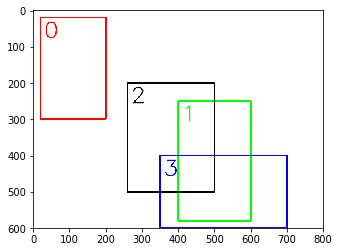

In [15]:
img = np.full((600, 800, 3), 255, dtype=img_source.dtype)

COLORS = [(255,0,0),(0,255,0),(0,0,0),(0,0,255)]
rects = [((20,20),(200,300)), ((400,250),(600,580)), ((260,200),(500,500)), ((350,400),(700,600))]
for i, rect in enumerate(rects):
    cv2.rectangle(img, rect[0], rect[1], COLORS[i], 3)
    cv2.putText(img, str(i), (rect[0][0] + 10, rect[0][1] + 55),
                cv2.FONT_HERSHEY_SIMPLEX,
                2,  COLORS[i], 2, cv2.LINE_AA)
    overlaps = [(j, overlap(rect, rect1)) for j,rect1 in enumerate(rects)]
    print("rect " + str(i) + " overlaps with ", overlaps)
    overlaps = [(j, estimate_answer([rect], [rect1])) for j,rect1 in enumerate(rects)]
    print("rect " + str(i) + " overlaps with ", overlaps)

plt.imshow(img)

In [16]:
def build_dataset_from_df(df):
    """
    this is temp way to prepare dataset
    """
    for _,row in df.iterrows():
        filename = row.filename
        detections = [[(row.xmin, row.ymin), (row.xmax, row.ymax)]]
        yield (filename, detections)

detector = SimpleHSVDetector()
dataset = build_dataset_from_df(df)
print(dataset)
print(calc_error(dataset, detector))

<generator object build_dataset_from_df at 0x7fe2cb0f2518>
36.0


## Train model parametrs.

We can improve the quality of the model by changing the next parameters:

* target color
* diaposon for target color
* threshholds
* window size
* clahe parametrs

To find the best parameters we can create a grid search of these parameters.

In [17]:
grid_search = {
    "color": [(h, s, v) for h in range(120, 135, 5) for s in range(60, 80, 5) for v in range(60, 80, 5)],
    "weight_color": [(h, s, v) for h in range(15, 30, 5) for s in range(35, 50, 5) for v in range(35, 50, 5)],
    "window_size": [150, 200, 250],
    "threshhold": [0.5 + i/10 for i in range(5)]
}

## Generate all combination

In [18]:
def all_combination(pairs):
    if len(pairs) == 0:
        yield []
    else:
        key, values = pairs[0]

        for val in values:
            for combination in all_combination(pairs[1:]):
                yield [(key, val)] + combination
    


    
list(all_combination(list(grid_search.items())))[1:19000:5030]

[[('color', (120, 60, 60)),
  ('weight_color', (15, 35, 35)),
  ('window_size', 150),
  ('threshhold', 0.6)],
 [('color', (120, 75, 60)),
  ('weight_color', (20, 35, 45)),
  ('window_size', 200),
  ('threshhold', 0.6)],
 [('color', (125, 70, 60)),
  ('weight_color', (25, 40, 40)),
  ('window_size', 250),
  ('threshhold', 0.6)],
 [('color', (130, 65, 65)),
  ('weight_color', (15, 45, 40)),
  ('window_size', 150),
  ('threshhold', 0.6)]]

In [ ]:
errors = []


for combination in all_combination(list(grid_search.items())):
    args_for_sample = dict(combination)
    detector = SimpleHSVDetector(**args_for_sample)
    dataset = build_dataset_from_df(df)
    error = calc_error(dataset, detector) 
    errors.append((error, args_for_sample))
    print(error, args_for_sample)

28.048915736302064 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 150, 'threshhold': 0.5}
34.20519027604611 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 150, 'threshhold': 0.6}
35.28545694727993 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 150, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 150, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 150, 'threshhold': 0.9}
33.90441778253813 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 200, 'threshhold': 0.5}
35.27332242225859 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 200, 'threshhold': 0.6}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 200, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 35, 35), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color

36.0 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 150, 'threshhold': 0.9}
29.390633206343004 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 200, 'threshhold': 0.5}
34.20228238801975 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 200, 'threshhold': 0.6}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 200, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 200, 'threshhold': 0.9}
33.216207480696234 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 250, 'threshhold': 0.5}
35.544714532750355 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 250, 'threshhold': 0.6}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 40, 45), 'window_size': 250, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (15, 40,

36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 200, 'threshhold': 0.9}
32.89431547889895 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 250, 'threshhold': 0.5}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 250, 'threshhold': 0.6}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 250, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 250, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 35, 40), 'window_size': 250, 'threshhold': 0.9}
20.779416713046704 {'color': (120, 60, 60), 'weight_color': (20, 35, 45), 'window_size': 150, 'threshhold': 0.5}
27.06644791686175 {'color': (120, 60, 60), 'weight_color': (20, 35, 45), 'window_size': 150, 'threshhold': 0.6}
34.18936022908941 {'color': (120, 60, 60), 'weight_color': (20, 35, 4

36.0 {'color': (120, 60, 60), 'weight_color': (20, 45, 35), 'window_size': 250, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 45, 35), 'window_size': 250, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 45, 35), 'window_size': 250, 'threshhold': 0.9}
14.145154848475773 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 150, 'threshhold': 0.5}
23.242828017105637 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 150, 'threshhold': 0.6}
29.97690082621178 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 150, 'threshhold': 0.7}
35.29132325264456 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 150, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 150, 'threshhold': 0.9}
21.877954292350438 {'color': (120, 60, 60), 'weight_color': (20, 45, 40), 'window_size': 200, 'threshhold': 0.5}
31.03856921788418 {'color': (120, 60, 60)

18.86399345376429 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 150, 'threshhold': 0.5}
23.897500125039638 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 150, 'threshhold': 0.6}
32.01082323533667 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 150, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 150, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 150, 'threshhold': 0.9}
22.30161380271021 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 200, 'threshhold': 0.5}
31.04620141302359 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 200, 'threshhold': 0.6}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 200, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 40, 35), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color

27.847116168396578 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 150, 'threshhold': 0.7}
33.92728055953761 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 150, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 150, 'threshhold': 0.9}
17.175049872823266 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 200, 'threshhold': 0.5}
28.20895630713045 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 200, 'threshhold': 0.6}
33.88794242303405 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 200, 'threshhold': 0.7}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 200, 'threshhold': 0.9}
25.304451172678853 {'color': (120, 60, 60), 'weight_color': (25, 45, 45), 'window_size': 250, 'threshhold': 0.5}
32.382251077584115 {'color':

34.198967594607 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 200, 'threshhold': 0.6}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 200, 'threshhold': 0.7}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 200, 'threshhold': 0.8}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 200, 'threshhold': 0.9}
33.21917237621456 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 250, 'threshhold': 0.5}
35.544714532750355 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 250, 'threshhold': 0.6}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 250, 'threshhold': 0.7}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 250, 'threshhold': 0.8}
36.0 {'color': (120, 60, 65), 'weight_color': (15, 40, 40), 'window_size': 250, 'threshhold': 0.9}
23.178382322449192 {'color': (120, 60, 65), 'weight_color': (15, 40, 45